# Create Heater Thermal Profiles

In [29]:
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def PCR_thermal_cycle(filename):

    filename_text = widgets.Text(value=filename, description="Filename")

    heat_rate = widgets.FloatSlider(value = 0.31, min=0.1, max=2, step=0.01, description='Heat Rate')
    cool_rate = widgets.FloatSlider(value = 0.31, min=0.1, max=2, step=0.01, description='Cooling Rate')
    cycles = widgets.IntSlider(value=3, min=1, max=30, description="PCR Cycles")

    denaturation_label = widgets.Label('Denaturation', layout=widgets.Layout(width='80px'))
    denaturation_temp = widgets.FloatSlider(value=94, min=92, max=98, step=0.1, description='Temperature', readout_format='0.1f')
    denaturation_dur = widgets.BoundedIntText(value=90, min=60, max=120, step=1, description='Duration')
    denaturation = widgets.HBox([denaturation_label, denaturation_temp, denaturation_dur])

    annealing_label = widgets.Label('Annealing', layout=widgets.Layout(width='80px'))
    annealing_temp = widgets.FloatSlider(value=60, min=50, max=65, step=0.1, description='Temperature', readout_format='0.1f')
    annealing_dur = widgets.BoundedIntText(value=60, min=30, max=120, step=1, description='Duration')
    annealing = widgets.HBox([annealing_label, annealing_temp, annealing_dur])

    extension_label = widgets.Label('Extension', layout=widgets.Layout(width='80px'))
    extension_temp = widgets.FloatSlider(value=70, min=68, max=72, step=0.1, description='Temperature', readout_format='0.1f')
    extension_dur = widgets.BoundedIntText(value=90, min=30, max=180, step=1, description='Duration')
    extension = widgets.HBox([extension_label, extension_temp, extension_dur])
    
   
    def create_setpoint_trajectory(
            filename_text,
            heat_rate, cool_rate, cycles,
            denaturation_temp, denaturation_dur, 
            annealing_temp, annealing_dur,
            extension_temp, extension_dur,):
        Ta = 22
        tp = [0]
        Tp = [Ta]   

        for k in range(0, cycles):
            # denaturation
            tp.append(tp[-1] + (denaturation_temp - Tp[-1]) / heat_rate)
            Tp.append(denaturation_temp)
            tp.append(tp[-1] + denaturation_dur)
            Tp.append(denaturation_temp)

            # annealing
            tp.append(tp[-1] - (annealing_temp - denaturation_temp) / cool_rate)
            Tp.append(annealing_temp)
            tp.append(tp[-1] + annealing_dur)
            Tp.append(annealing_temp)

            # extension
            tp.append(tp[-1] + (extension_temp - annealing_temp) / heat_rate)
            Tp.append(extension_temp)
            tp.append(tp[-1] + extension_dur)
            Tp.append(extension_temp)
            
    

        tp.append(tp[-1] - (Ta - Tp[-1]) / cool_rate)
        Tp.append(Ta)
        fig, ax = plt.subplots(1, 1, figsize=(1 + max(tp)/500, 5))
        ax.plot(tp, Tp)
        ax.set_xlabel('time / sec')
        ax.set_ylabel('temperature / deg C')
        ax.set_title('PCR Temperature Program')
        ax.plot(tp, Tp, 'r.', ms=3)
        ax.grid(True)
        df = pd.DataFrame()
        df['tp'] = tp
        df['Tp'] = Tp
        df.to_csv(filename_text)

    display(filename_text)
    display(heat_rate)
    display(cool_rate)
    display(cycles)
    display(denaturation)
    display(annealing)
    display(extension)

    out = widgets.interactive_output(create_setpoint_trajectory, {
        'filename_text': filename_text,
        'heat_rate': heat_rate, 
        'cool_rate': cool_rate,
        'cycles': cycles,
        'denaturation_temp': denaturation_temp,
        'denaturation_dur': denaturation_dur,
        'annealing_temp': annealing_temp,
        'annealing_dur': annealing_dur,
        'extension_temp': extension_temp,
        'extension_dur': extension_dur,
        })

    display(out)

### Create Heater 1 Profile

In [30]:
PCR_thermal_cycle('pcr/pcr1.csv')

Text(value='pcr/pcr1.csv', description='Filename')

FloatSlider(value=0.31, description='Heat Rate', max=2.0, min=0.1, step=0.01)

FloatSlider(value=0.31, description='Cooling Rate', max=2.0, min=0.1, step=0.01)

IntSlider(value=3, description='PCR Cycles', max=30, min=1)

Output()

### Create Heater 2 Profile

In [20]:
PCR_thermal_cycle('pcr/pcr2.csv')

Text(value='pcr/pcr2.csv', description='Filename')

FloatSlider(value=0.31, description='Heat Rate', max=2.0, min=0.1, step=0.01)

FloatSlider(value=0.31, description='Cooling Rate', max=2.0, min=0.1, step=0.01)

IntSlider(value=3, description='PCR Cycles', max=30, min=1)

Output()

## Translate Requested Profiles to Setpoints

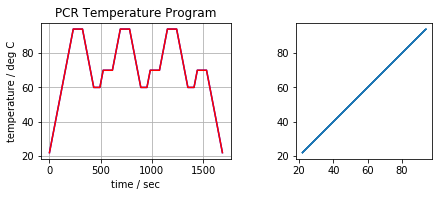

In [24]:
import glob
import matplotlib.pyplot as plt
import pandas as pd

def get_data(file1, file2):
    fig, ax = plt.subplots(1,2, figsize=(7.5,2.5))
    if file1:
        df1 = pd.read_csv(file1)
        ax[0].plot(df1['tp'], df1['Tp'], 'b')
    if file2:
        df2 = pd.read_csv(file2)
        ax[0].plot(df2['tp'], df2['Tp'], 'r')
    ax[0].grid(True)
    ax[0].set_xlabel('time / sec')
    ax[0].set_ylabel('temperature / deg C')
    ax[0].set_title('PCR Temperature Program')
    if file1 and file2:
        tmax = max(df1['tp'].max(), df2['tp'].max())
        t = np.linspace(0, tmax, int(tmax+1))
        u1 = lambda t: np.interp(t, df1['tp'].to_numpy(), df1['Tp'].to_numpy())
        u2 = lambda t: np.interp(t, df2['tp'].to_numpy(), df2['Tp'].to_numpy())
        ax[1].plot(u1(t), u2(t))
        ax[1].axis('square')
        return t, u1, u2, tmax

t_ref, u1, u2, tmax = get_data('pcr/pcr1.csv', 'pcr/pcr2.csv')
